# Import and helpers functions
---
- `get_driving_log` reads the csv that contains all the image names and steering angles
- `generator` is a function that creates the image generator (used for both training and validation sets)

In [ ]:
import os
import csv
import cv2
import numpy as np
import random
import math

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Dropout, Cropping2D
import sklearn
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Preparing the dataset and generators
---
The below code loads all the images from the relevant path, splits the dataset between training and validation and creates the generators. We are creating 6 images per line in the driving log (left, right, center images and their flipped version), so a batch_size of **32** is in fact equivalent to **192** training samples.

In [5]:
def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HLS2RGB)

In [9]:
def get_driving_log(path):
    lines = []
    with open(path + 'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
            
    return lines

In [16]:
del_angle = 0.001
del_rate = 0.5

def generator(path, samples, batch_size=128, shuffle=True):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for image_nb in [0, 1, 2]:
                    name = path + 'IMG/'+ batch_sample[image_nb].split('/')[-1]
                    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
                    image = random_brightness(image)
                    shift_dict = {0: 0, 1: 0.27, 2: -0.27}
                    angle = float(batch_sample[3]) + shift_dict.get(image_nb, "error")

                    images.append(np.fliplr(image))
                    angles.append(-angle)
                
                    images.append(image)
                    angles.append(angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train) if shuffle else (X_train, y_train)

In [17]:
path = './data_Udacity_2/'

samples = get_driving_log(path)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(path, train_samples, batch_size=32)
validation_generator = generator(path, validation_samples, batch_size=32)

# Visualizing the data 
---
Here we show some samples of our training data set:
- Center | Left | Right images: left/right images have their steering angle modified by +/- 0.27
- Flipped images with flipped steering angles

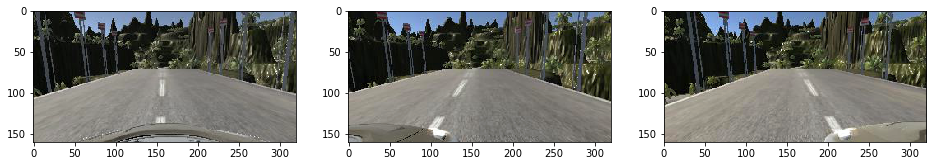

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

unshuffled = generator(path, train_samples, batch_size=128, shuffle=False)
sample_images, _ = next(unshuffled)

# Center |Left |Right images
fig = plt.figure(figsize=(16,4))

for image_nb in [1,2,3]:
    fig.add_subplot(1,3,image_nb)
    sample_image = sample_images[2*(image_nb-1)]
    plt.imshow(sample_image)

plt.savefig('center-left-right_samples.png')

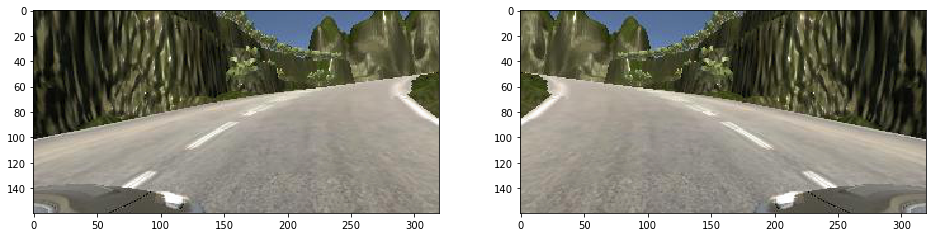

In [32]:
fig = plt.figure(figsize=(16,4))

for image_nb in [1,2]:
    fig.add_subplot(1,2,image_nb)
    sample_image = sample_images[+image_nb]
    plt.imshow(sample_image)

plt.savefig('flipped_samples.png')

# Model Architecture
---
This is where we define the convolutional neural network that learns how to drive autonomously. See `readme.md` for more explanations about this architecture.

In [8]:
# ------ Training/Validation data loading -------

path = './data_Udacity_2/'

samples = get_driving_log(path)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(path, train_samples, batch_size=32)
validation_generator = generator(path, validation_samples, batch_size=32)

# Resize images as required for network.
def resize_im(x):
    from keras.backend import tf
    return tf.image.resize_images(x, (66, 160))

#NVIDIA Model
model = Sequential()
model.add(Cropping2D(cropping=((70,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 127.5 - 1))
model.add(Lambda(resize_im))

model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))

model.add(Conv2D(64, 3, 3, activation='elu'))

model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 70, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 70, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 66, 160, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 78, 24)    1824        lambda_2[0][0]                   
___________________________________________________________________________________________

# Model Training
---
Below we train the model, print the training and validation error and finally save the model so that it can be used by the driving script.

In [33]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch = len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5, callbacks=[checkpoint], verbose=1)

model.save('model_viz.h5')

# Explicitly end tensorflow session
from keras import backend as K
    
K.clear_session()

Epoch 1/5
46848/47036 [============================>.] - ETA: 1s - loss: 0.0847

/Users/anil/anaconda/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


47040/47036 [==============================] - 546s - loss: 0.0846 - val_loss: 0.0674
Epoch 2/5
47040/47036 [==============================] - 617s - loss: 0.0628 - val_loss: 0.0532
Epoch 3/5
47040/47036 [==============================] - 526s - loss: 0.0569 - val_loss: 0.0526
Epoch 4/5
47040/47036 [==============================] - 526s - loss: 0.0508 - val_loss: 0.0498
Epoch 5/5
47040/47036 [==============================] - 554s - loss: 0.0451 - val_loss: 0.0420


# plot the training and validation loss


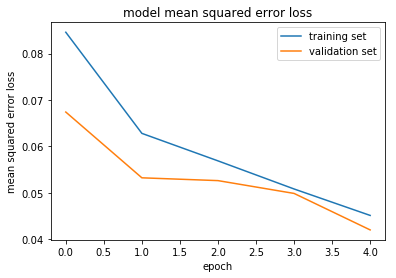

In [34]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()